# PlantGrowth

## 1. Introduction

In this project, we analyse the **PlantGrowth** dataset. It contains plant weights for three groups:

- **ctrl** (control)  
- **trt1** (treatment 1)  
- **trt2** (treatment 2)

We want to:
1. Describe the dataset
2. Explain t-tests and perform a t-test between `trt1` and `trt2`
3. Explain and perform ANOVA across `ctrl`, `trt1`, and `trt2`
4. Justify why ANOVA is more appropriate than multiple t-tests for three or more groups

We will document each step in Markdown cells and keep the code organised.

---


# 2. Data Import & Setup


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway, shapiro, levene
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Path to data
url = "https://raw.githubusercontent.com/nf-me/8651-applied-statistics/refs/heads/main/data/PlantGrowth.csv"
df = pd.read_csv(url)

# Group is categorical
df['group'] = df['group'].astype('category')

# review the data
display(df.head())

# Basic descriptive stats
print("\nBasic Summary by Group:")
print(df.groupby('group')['weight'].describe().round(3))


,rownames,weight,group
0,1,4.17,ctrl
1,2,5.58,ctrl
2,3,5.18,ctrl
3,4,6.11,ctrl
4,5,4.50,ctrl



Basic Summary by Group:
       count   mean    std   min    25%    50%    75%   max
group                                                      
ctrl    10.0  5.032  0.583  4.17  4.550  5.155  5.292  6.11
trt1    10.0  4.661  0.794  3.59  4.208  4.550  4.870  6.03
trt2    10.0  5.526  0.443  4.92  5.268  5.435  5.735  6.31


C:\Users\neilf\AppData\Local\Temp\ipykernel_4268\3452157924.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('group')['weight'].describe().round(3))


# 3. T-test Explanation & Code

A t-test compares the means of two groups to see if they differ significantly.
Key assumptions:
1. Observations in each group are independent.
2. The data in each group is (roughly) normally distributed.
3. The variances of the two groups are equal (for the standard independent t-test).

We will check normality (Shapiro–Wilk) and variance equality (Levene's test)
before performing the t-test between 'trt1' and 'trt2'.
"""


## Description of Dataset

Each row represents a single plant's weight and the treatment group it belongs to.  
- **Observations**: Typically 30 (10 plants per group).  
- **Variables**:  
  - `group`: Categorical (ctrl, trt1, trt2)  
  - `weight`: Numeric, representing plant weight.

---


In [2]:
# Separate the two treatment groups
trt1 = df.loc[df['group'] == 'trt1', 'weight']
trt2 = df.loc[df['group'] == 'trt2', 'weight']

# Check normality
w1, p1 = shapiro(trt1)
w2, p2 = shapiro(trt2)
print(f"Shapiro–Wilk (trt1): p={p1:.4f}, (trt2): p={p2:.4f}")

# Check variance homogeneity (Levene's)
lev_stat, lev_p = levene(trt1, trt2)
print(f"Levene's test: p={lev_p:.4f}")

# Perform t-test
t_stat, t_p = ttest_ind(trt1, trt2, equal_var=True)
print(f"\nT-test (trt1 vs. trt2): t={t_stat:.3f}, p={t_p:.4f}")


Shapiro–Wilk (trt1): p=0.4519, (trt2): p=0.5643
Levene's test: p=0.1641

T-test (trt1 vs. trt2): t=-3.010, p=0.0075


**Interpretation:**  
- If `p < 0.05`, we usually conclude that `trt1` and `trt2` have statistically different mean weights.  
- The normality and variance checks help confirm the suitability of a standard t-test.

---

## 4. ANOVA Explanation
An **Analysis of Variance (ANOVA)** compares the means of three (or more) groups simultaneously.  

**Key assumptions:**  
1. Independence of observations  
2. Each group is (approximately) normally distributed  
3. Homogeneity of variances across groups  

We prefer ANOVA over multiple t-tests to avoid inflating the Type I error rate.
If we run many t-tests, each with a 5% chance of a false positive, overall error can become much higher. ANOVA controls this by performing *one* overall test first.

---


# 5. ANOVA: ctrl, trt1, and trt2


Shapiro p-values => ctrl: 0.7475, trt1: 0.4519, trt2: 0.5643
Levene's test (all 3 groups): p=0.3412

ANOVA (ctrl, trt1, trt2): F=4.846, p=0.0159

Post-hoc (Tukey HSD):
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  ctrl   trt1   -0.371 0.3909 -1.0622 0.3202  False
  ctrl   trt2    0.494  0.198 -0.1972 1.1852  False
  trt1   trt2    0.865  0.012  0.1738 1.5562   True
---------------------------------------------------


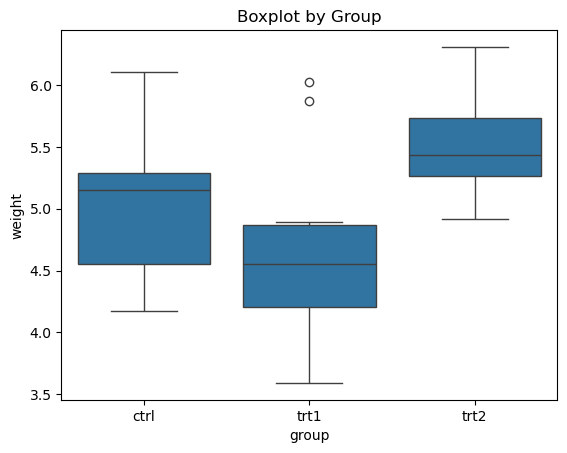

In [3]:
# Quick normality checks for all groups
ctrl = df.loc[df['group'] == 'ctrl', 'weight']
shapiro_ctrl = shapiro(ctrl)
shapiro_trt1 = shapiro(trt1)
shapiro_trt2 = shapiro(trt2)
print(f"Shapiro p-values => ctrl: {shapiro_ctrl[1]:.4f}, trt1: {shapiro_trt1[1]:.4f}, trt2: {shapiro_trt2[1]:.4f}")

# Levene's for all 3
lev_stat_3, lev_p_3 = levene(ctrl, trt1, trt2)
print(f"Levene's test (all 3 groups): p={lev_p_3:.4f}")

# One-way ANOVA
f_stat, f_p = f_oneway(ctrl, trt1, trt2)
print(f"\nANOVA (ctrl, trt1, trt2): F={f_stat:.3f}, p={f_p:.4f}")

# If significant, we can do a Tukey HSD post-hoc to see which groups differ:
if f_p < 0.05:
    print("\nPost-hoc (Tukey HSD):")
    tukey = pairwise_tukeyhsd(df['weight'], df['group'], alpha=0.05)
    print(tukey)

# Simple boxplot for visual
sns.boxplot(data=df, x='group', y='weight')
plt.title("Boxplot by Group")
plt.show()


## 6. Why ANOVA Rather Than Multiple T-tests?

When we have three groups (like `ctrl`, `trt1`, `trt2`), comparing them pairwise with multiple t-tests (ctrl vs trt1, ctrl vs trt2, trt1 vs trt2) increases the chance of falsely detecting a difference (Type I error). ANOVA does a single omnibus test to see if *any* of the group means differ, effectively controlling the overall Type I error. If it’s significant, we can then do a **post-hoc** test (like Tukey) to identify *which* groups differ.

---


# 7. Conclusion

Conclusion:
1. We performed a t-test between trt1 and trt2.
2. We conducted an ANOVA across ctrl, trt1, and trt2.
3. We explained why ANOVA is more appropriate than multiple t-tests.
4. We used basic assumption checks and simple plots.

In [5]:
print("All analyses complete.")

All analyses complete.


## References
- [Vincent Arel-Bundock's Rdatasets](https://vincentarelbundock.github.io/Rdatasets/)  
- [Scipy Stats Documentation](https://docs.scipy.org/doc/scipy/reference/stats.html)  
- [Statsmodels Documentation](https://www.statsmodels.org/)  

**End of Notebook**
